<a href="https://colab.research.google.com/github/daryaami/ML-for-Scientific-Data-Analysis-Course/blob/hometask_1/Task1_Data_research_and_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Датасет для прогнозирования сердечной недостаточности

### Description
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal] **TARGET**




## Анализ задачи и выбор метрики

**Задача:** Целевым признаком в датасете выступает HeartDisease, то есть наличие или отсутсвие болезней сердца. Так как целевой признак - бинарный, задача является задачей *классификации*. Воспользуемся моделью логистической регрессии




-





**Метрика:** Для оценки бинарной классификации подходят различные метрики: Accuracy, Precision, Recall, f-score... Так как f-мера является наиболее полной метрикой, в данном датасете я буду использовать именно ее. В качестве параметра бета использую 1, чтобы Precision и Recall в одинаковой мере влияли на метрику.

---



## Импорт

In [4]:
!pip install category_encoders > None

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

## Preprocessing

In [6]:
data = pd.read_csv('heart.csv')
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Бинарные признаки можно закодировать Label Encoder'ом. Признаки с уникальными значениями более двух можно закодировать One Hot или Binary Encoder

Label Encoding

In [8]:
for col in ['Sex', 'ExerciseAngina']:
    le = LabelEncoder()
    data[col + '_encoded'] = le.fit_transform(data[col])
    print(le.classes_)

['F' 'M']
['N' 'Y']


One Hot Encoding

In [9]:
for col in ['RestingECG']:
    encoded_data = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, encoded_data], axis=1)

Binary Encoding

In [10]:
for col in ['RestingECG']:
    be = BinaryEncoder(cols=['ChestPainType'])
    data = be.fit_transform(data)
    be.get_feature_names_out()

ST_Slope можно закодировать с помощью метода map, так как есть явная полярность значений

In [11]:
data['ST_Slope'] = data['ST_Slope'].map({'Down': 1, 'Flat': 0, 'Up': -1})

In [12]:
data = data.drop(['RestingECG', 'Sex', 'ExerciseAngina'], axis=1)

In [13]:
data.describe()

,Age,ChestPainType_0,ChestPainType_1,ChestPainType_2,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_encoded,ExerciseAngina_encoded,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.050109,0.761438,0.728758,132.396514,198.799564,0.233115,136.809368,0.887364,-0.361656,0.553377,0.789760,0.404139,0.204793,0.601307,0.193900
std,9.432617,0.218289,0.426437,0.444843,18.514154,109.384145,0.423046,25.460334,1.066570,0.607056,0.497414,0.407701,0.490992,0.403770,0.489896,0.395567
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,1.000000,0.000000,120.000000,173.250000,0.000000,120.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,1.000000,1.000000,130.000000,223.000000,0.000000,138.000000,0.600000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,60.000000,0.000000,1.000000,1.000000,140.000000,267.000000,0.000000,156.000000,1.500000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,77.000000,1.000000,1.000000,1.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## EDA

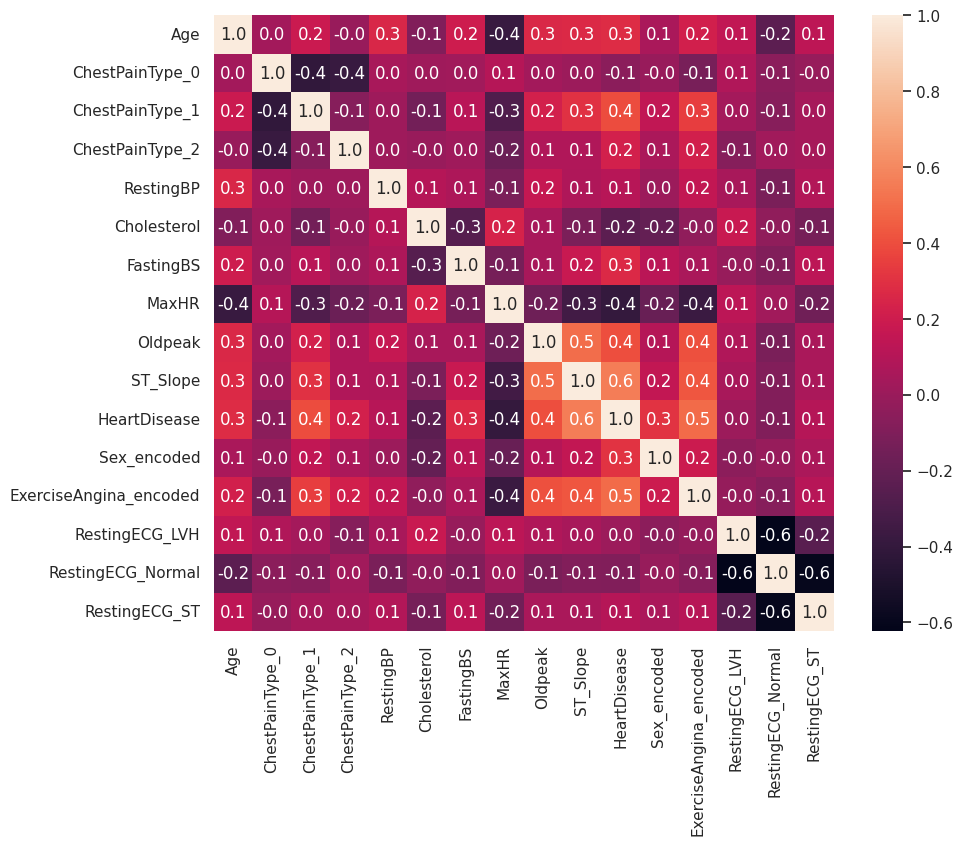

In [14]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.heatmap(data.corr(), annot=True, fmt=".1f");

Нет слишком больших корреляций с целевым признаком, значит не наблюдается мультиколлинеарность. Больше всего с таргетом коррелируют - ExerciseAngina, ST_Slope, Sex, Age, MaxHR

Можно рассмотреть гистограммы каждого признака

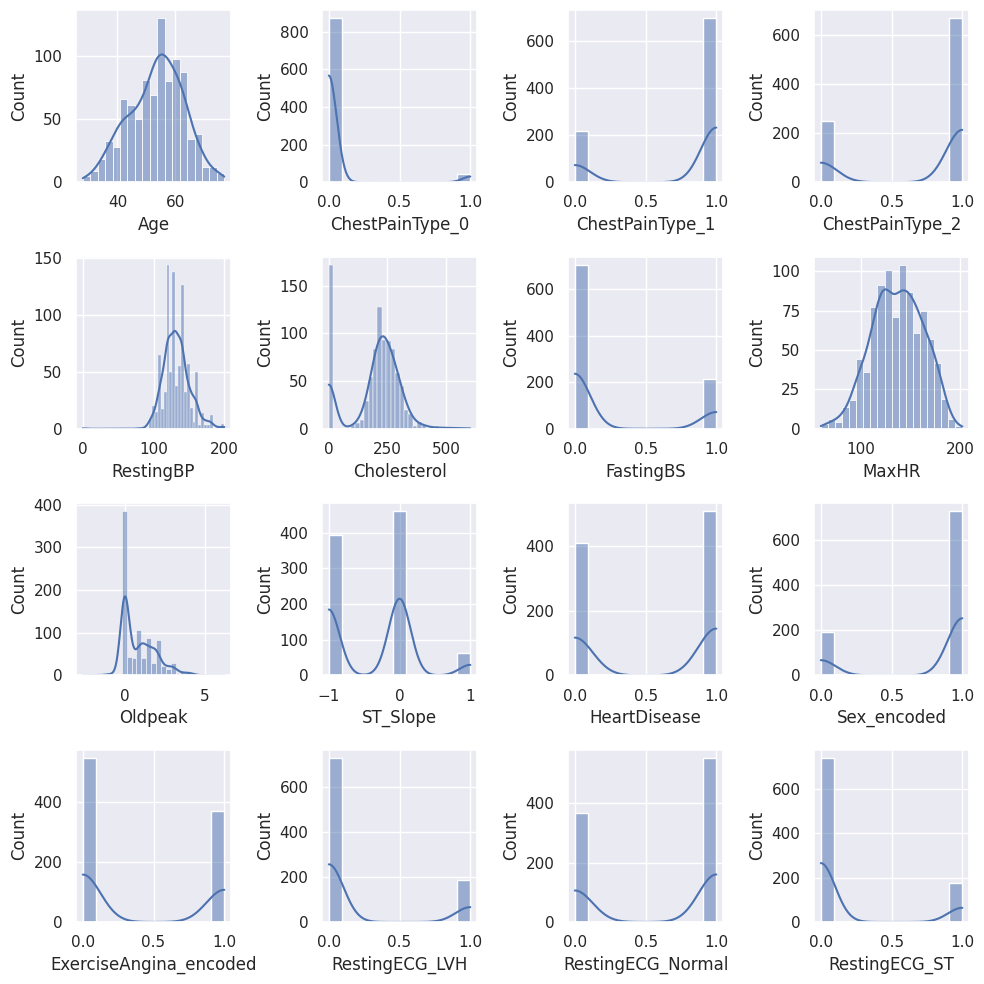

In [15]:
num_rows = len(data.columns) // 4
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, feature in enumerate(data.columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data[feature], kde=True, ax=axes[row][col])
    axes[row][col].set_xlabel(feature)

plt.tight_layout()
plt.show()

Рассмотрим признак Cholesterol - в его распределении видно большое кол-во пропущенных значений

In [16]:
data[data['Cholesterol']==0]['Cholesterol'].count()

172

In [17]:
data[data['Cholesterol']==0].groupby('HeartDisease')['HeartDisease'].count()

HeartDisease
0     20
1    152
Name: HeartDisease, dtype: int64

Столбец Cholesterol может привести к утечке данных целевого признака при обучении, поэтому его целесообразно удалить.

In [18]:
data = data.drop('Cholesterol', axis=1)



---



In [19]:
cols = ['Age', 'RestingBP', 'FastingBS', 'MaxHR', 'Oldpeak', 'ST_Slope', 'HeartDisease', 'Sex_encoded', 'ExerciseAngina_encoded']

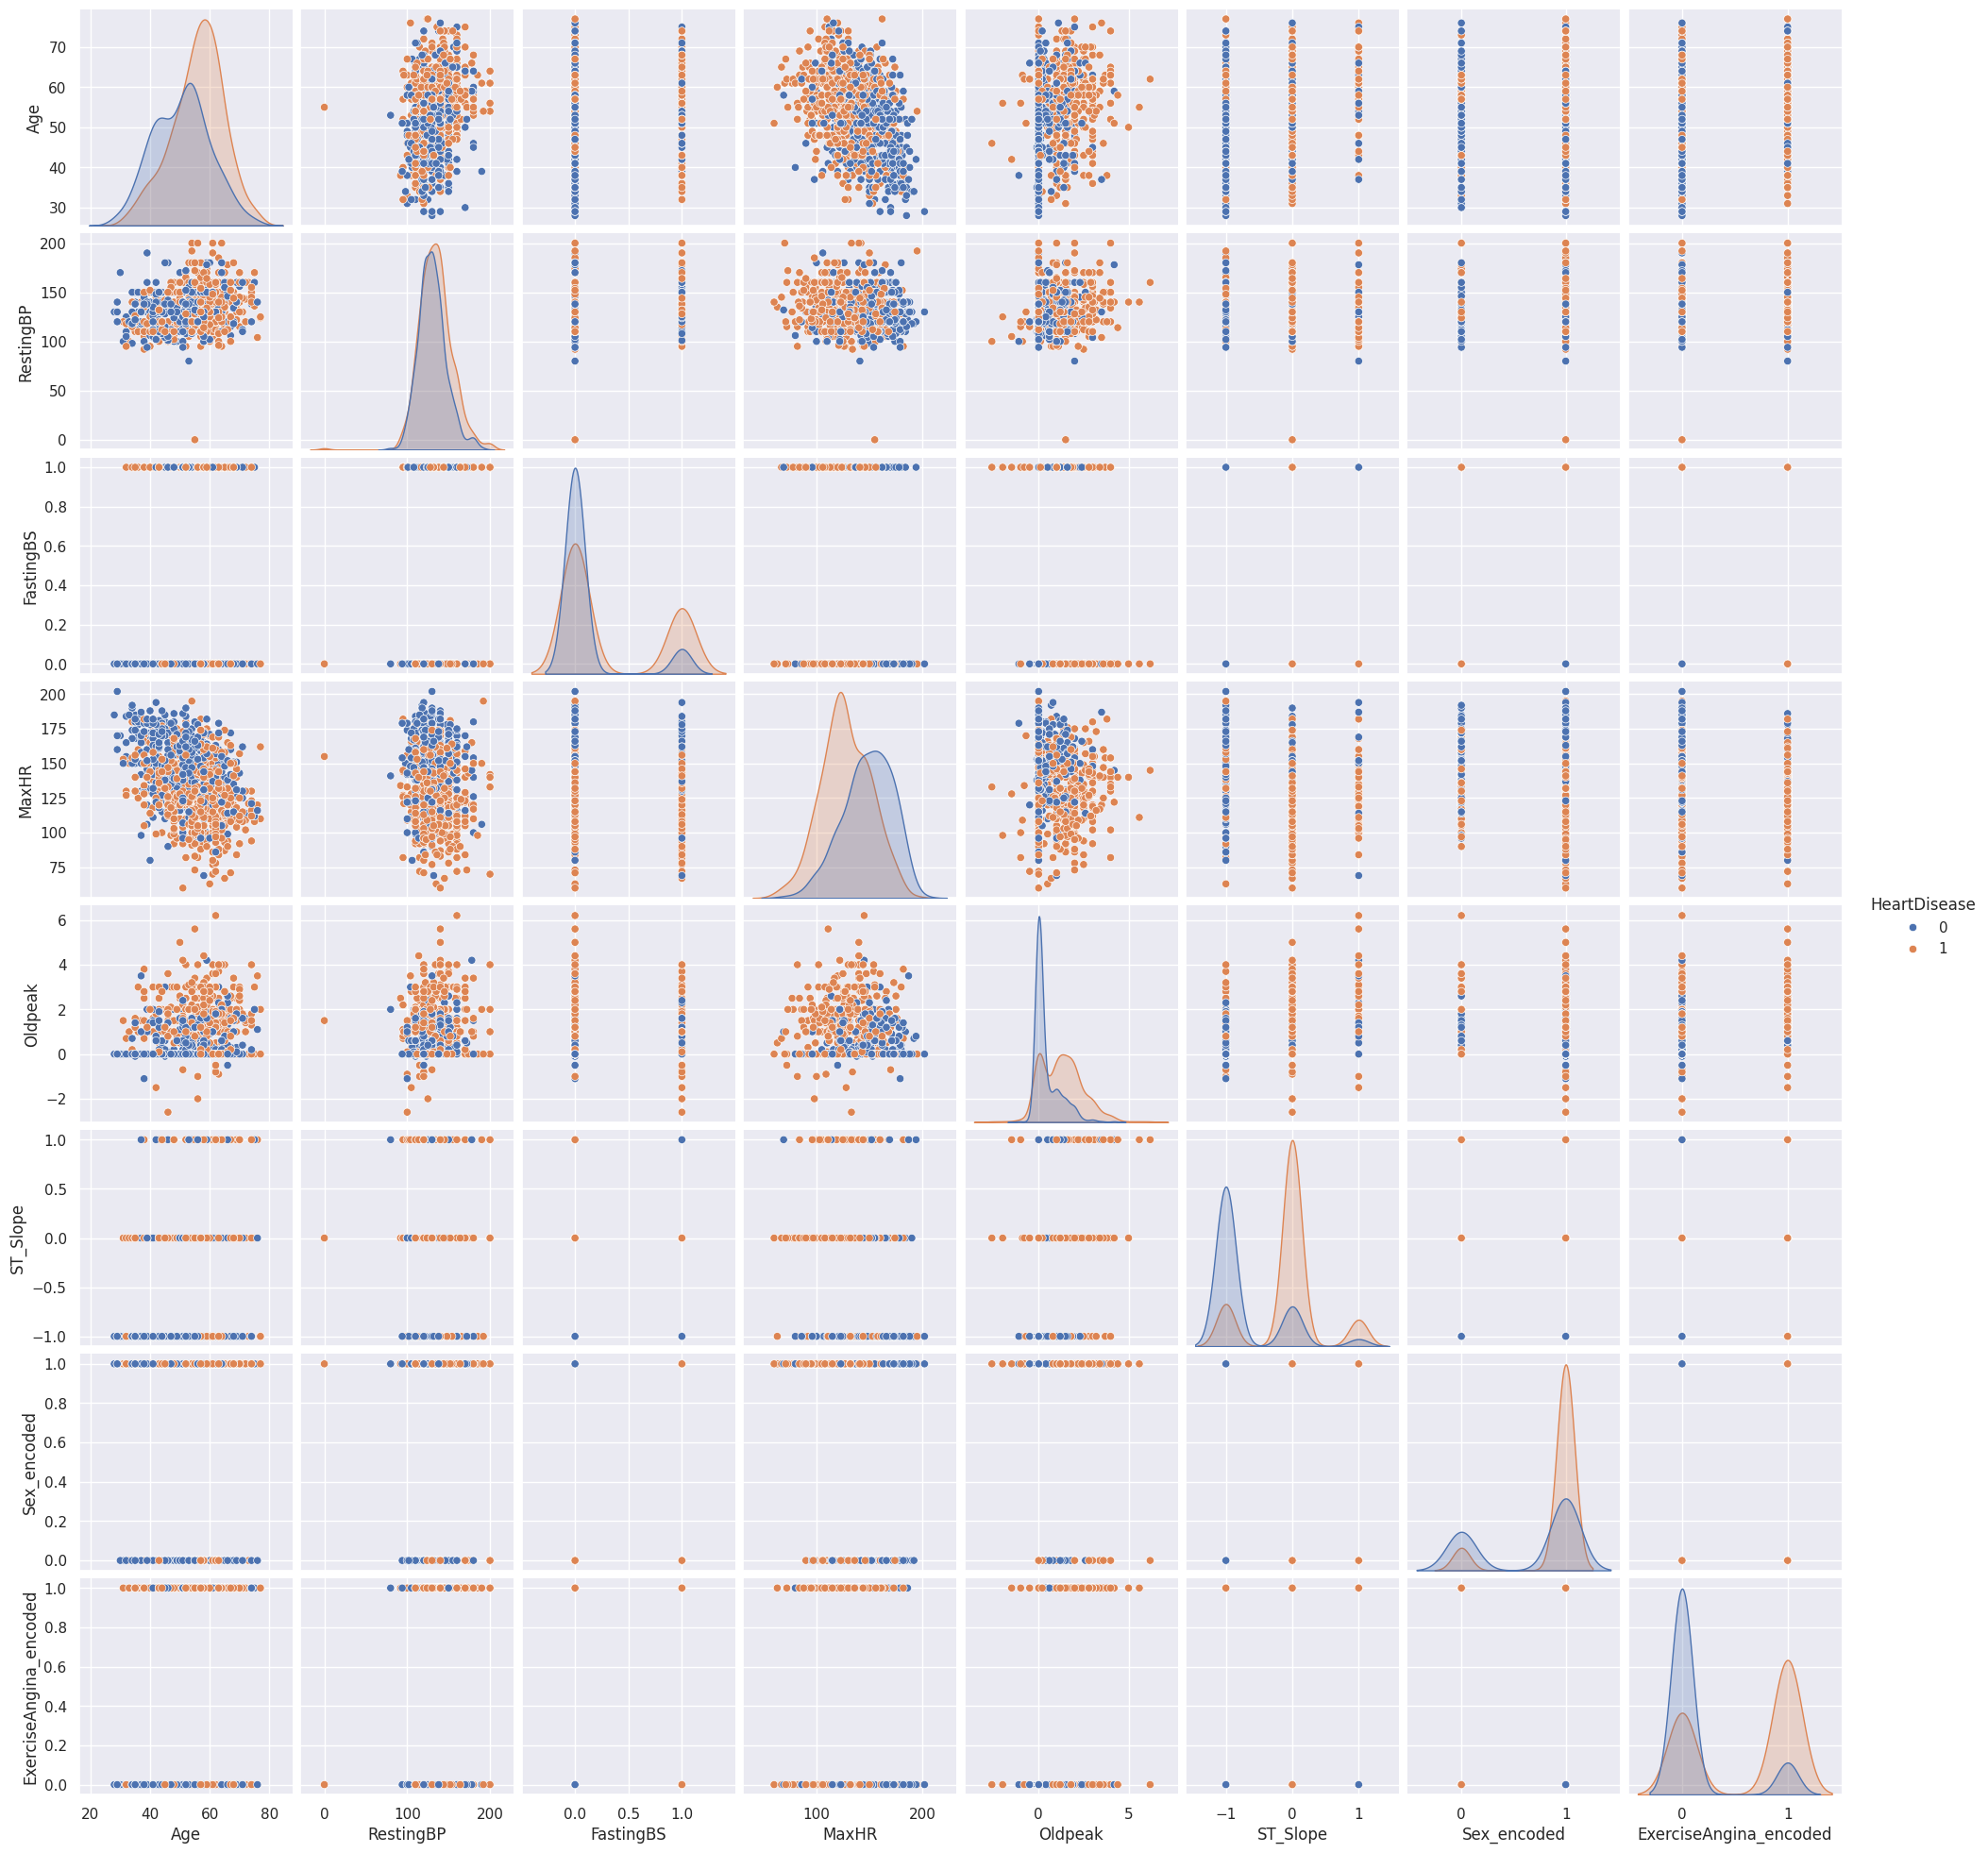

In [20]:
sns.pairplot(data[cols], hue="HeartDisease");

Посмотрим на выбросы

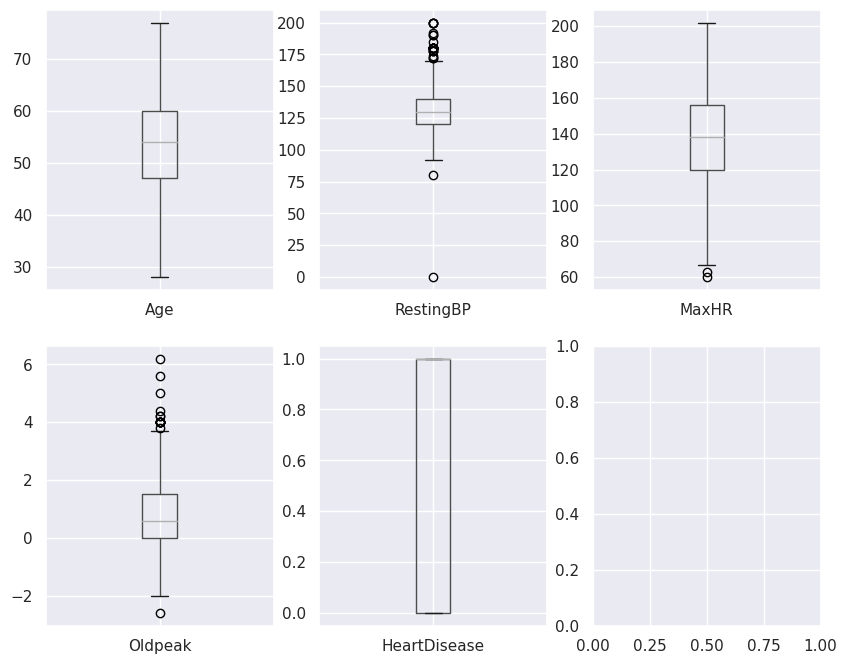

In [21]:
box_plot_df = data[['Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'HeartDisease']]
n_cols = 3
n_rows = box_plot_df.shape[1] // 3 + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))
for i, feature in enumerate(box_plot_df.columns):
    data.boxplot(column=feature, ax=axes[i // 3][i % 3])
    plt.grid(True)
plt.show()

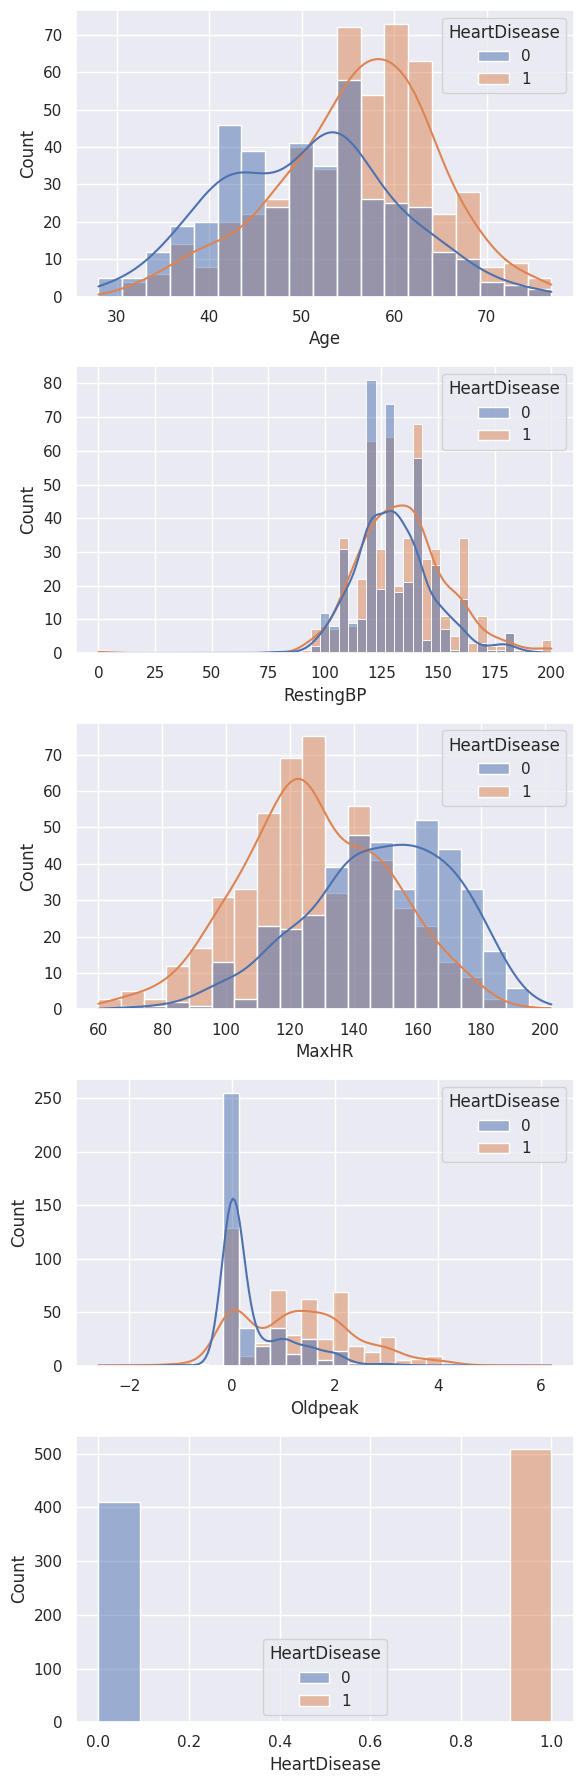

In [22]:
fig, axes = plt.subplots(nrows=len(box_plot_df.columns), ncols= 1, figsize=(6, 18))

for i, feature in enumerate(box_plot_df.columns):
    sns.histplot(data=box_plot_df, x=feature, hue='HeartDisease', kde=True, ax=axes[i]);

plt.tight_layout()
plt.show()

## Baseline

Реализуем константную модель, с которой будем сравнивать остальные.

In [23]:
data.head()

,Age,ChestPainType_0,ChestPainType_1,ChestPainType_2,RestingBP,FastingBS,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_encoded,ExerciseAngina_encoded,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,0,0,1,140,0,172,0.0,-1,0,1,0,0,1,0
1,49,0,1,0,160,0,156,1.0,0,1,0,0,0,1,0
2,37,0,0,1,130,0,98,0.0,-1,0,1,0,0,0,1
3,48,0,1,1,138,0,108,1.5,0,1,0,1,0,1,0
4,54,0,1,0,150,0,122,0.0,-1,0,1,0,0,1,0


In [24]:
X, y = data.drop(['HeartDisease'], axis=1), data['HeartDisease']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=22,
                                                    test_size=0.2,
                                                    stratify=y)

In [26]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

print("f1_score: ", f1_score(y_test, dummy_pred))
print(confusion_matrix(y_test, dummy_pred))

f1_score:  0.7132867132867133
[[  0  82]
 [  0 102]]


Логистическая регрессия

In [27]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=22))])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print("f1_score: ", f1_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

f1_score:  0.848780487804878
[[66 16]
 [15 87]]


K Nearest Neighbors

In [28]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=3))])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print("f1_score: ", f1_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

f1_score:  0.8341232227488152
[[61 21]
 [14 88]]


Decision Tree Classifier

In [29]:
pipeline = Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeClassifier(criterion='gini', max_depth=6))])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print("f1_score: ", f1_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

f1_score:  0.838095238095238
[[62 20]
 [14 88]]


Полиномизация

In [38]:
polynomial_features = PolynomialFeatures(degree=4, include_bias=True)
pipeline = Pipeline([('polynomial', polynomial_features), ('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=3))])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
3
print("f1_score: ", f1_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

f1_score:  0.8557692307692308
[[65 17]
 [13 89]]


В целом все модели показали похожий результат - около 0.84, что лучше результата модели-болванки (0,71). С помощью полиномизации и логистической регрессии получилось достичь результата 0.855. Возможно, качество предсказаний можно увеличить, используя более сложные модели.